# Spotify song popularity prediction - Model Creation

In [14]:
# Importing all the necessary packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, fbeta_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, pair_confusion_matrix, accuracy_score
import pickle as pkl
from sklearn.utils.class_weight import compute_class_weight

In [15]:
spotify_data = pd.read_csv('spotify_data.csv', index_col=0)

### 1. Data Exploration

In [16]:
spotify_data = spotify_data[spotify_data['popularity']!=0]

In [17]:
spotify_data.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [18]:
spotify_data.describe()

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06,1.001373e+06
mean,2.129085e+01,2.012402e+03,5.363992e-01,6.428674e-01,5.281454e+00,-8.830127e+00,6.349272e-01,9.340289e-02,3.153963e-01,2.408593e-01,2.241756e-01,4.522004e-01,1.214418e+02,2.460179e+05,3.889541e+00
std,1.517754e+01,6.731271e+00,1.831011e-01,2.683754e-01,3.556199e+00,5.642178e+00,4.814508e-01,1.295901e-01,3.488115e-01,3.600826e-01,2.029890e-01,2.671552e-01,2.998246e+01,1.393387e+05,4.554628e-01
min,1.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.661000e+03,0.000000e+00
25%,9.000000e+00,2.007000e+03,4.140000e-01,4.610000e-01,2.000000e+00,-1.057800e+01,0.000000e+00,3.670000e-02,7.110000e-03,0.000000e+00,9.840000e-02,2.250000e-01,9.823200e+01,1.817070e+05,4.000000e+00
50%,1.800000e+01,2.013000e+03,5.490000e-01,6.970000e-01,5.000000e+00,-7.288000e+00,1.000000e+00,5.000000e-02,1.460000e-01,1.150000e-03,1.340000e-01,4.330000e-01,1.210800e+02,2.246290e+05,4.000000e+00
75%,3.100000e+01,2.018000e+03,6.740000e-01,8.730000e-01,8.000000e+00,-5.194000e+00,1.000000e+00,8.890000e-02,6.180000e-01,5.520000e-01,2.920000e-01,6.680000e-01,1.399860e+02,2.813070e+05,4.000000e+00
max,1.000000e+02,2.023000e+03,9.930000e-01,1.000000e+00,1.100000e+01,6.172000e+00,1.000000e+00,9.700000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.497920e+02,6.000495e+06,5.000000e+00


In [19]:
spotify_data.year.value_counts(sort=False)

2012    47820
2013    46686
2014    47350
2015    46760
2016    37358
2017    51901
2018    52529
2019    52672
2020    51806
2021    50874
2022    51541
2023    31600
2000    33341
2001    32658
2002    32875
2003    33428
2004    34281
2005    35694
2006    36588
2007    37234
2008    38007
2009    38928
2010    39783
2011    39659
Name: year, dtype: int64

In [20]:
# Check for null or na values if any

spotify_data.isna().sum()

artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

##### <p>Now, there are no null or na values. We can check for duplicate values if any </p>

In [21]:
spotify_data.duplicated().sum()

0

In [22]:
# We can use artist and popularity in our feature engineering as it seems like a great feature to consider
spotify_data['popularity'].groupby(spotify_data['artist_name']).agg(['median','count'])

,median,count
artist_name,,
!!!,22.0,44
!T.O.O.H.!,1.0,10
"""DEMONS""",3.0,3
"""Weird Al"" Yankovic",34.0,25
#90s Update,33.0,3
...,...,...
조장혁,6.5,4
조정현,16.5,2
채연,9.0,9


In [23]:
# Similarly for genre we will check if we can utilize this 
spotify_data['popularity'].groupby(spotify_data['genre']).agg(['median','count'])

,median,count
genre,,
acoustic,18.0,19393
afrobeat,8.0,8920
alt-rock,37.0,20794
ambient,21.0,20058
black-metal,11.0,19824
...,...,...
swedish,17.0,11504
tango,3.0,6505
techno,17.0,6441


In [24]:
# we might have to take care of tempo in data preprocessing
spotify_data['tempo'].value_counts()

0.000      769
119.999    357
120.002    346
120.006    342
128.001    334
          ... 
173.253      1
219.933      1
172.614      1
66.492       1
161.509      1
Name: tempo, Length: 132579, dtype: int64

In [25]:
spotify_data.shape

(1001373, 19)

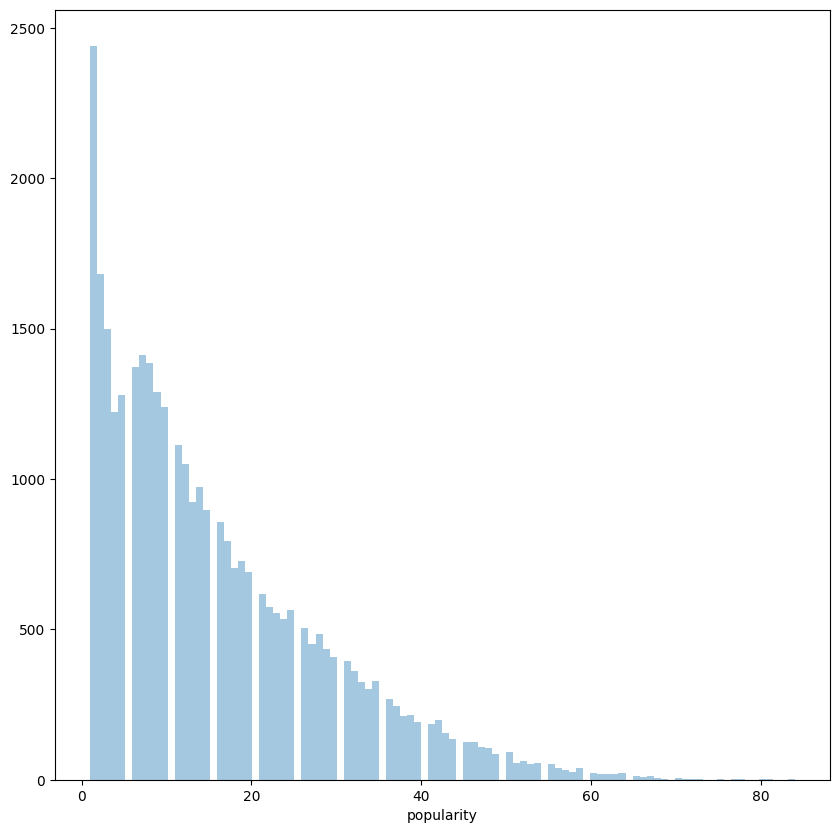

In [26]:
plt.figure(figsize=(10,10))
sns.distplot(spotify_data[spotify_data['year']==2003]['popularity'], bins =100, kde= False)
plt.show()

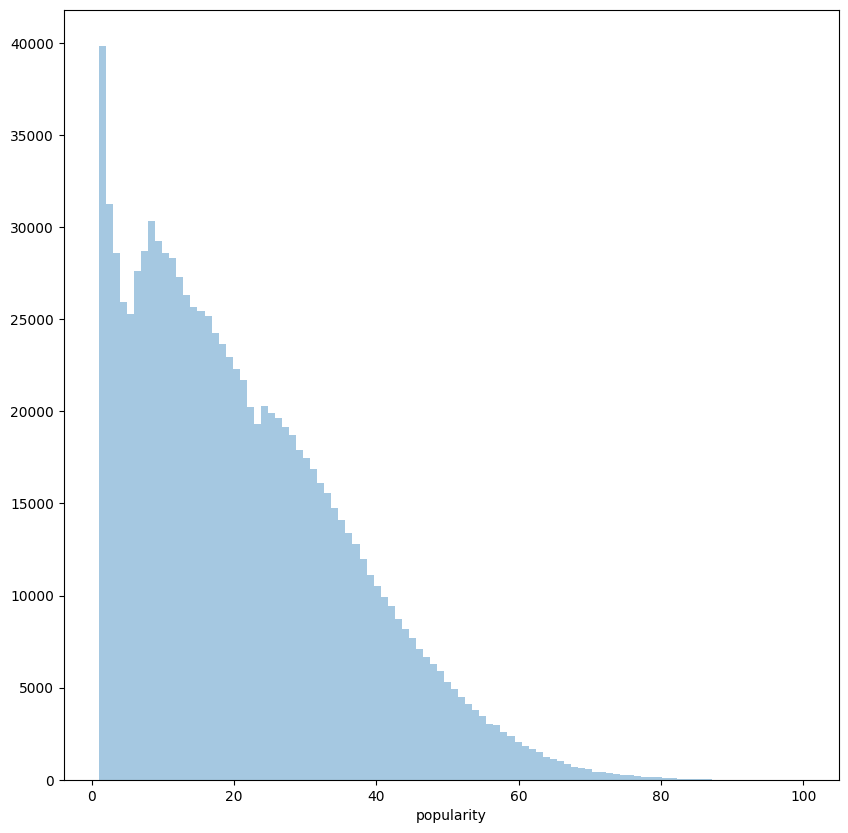

In [27]:
# We will visualize the score of the popularity which will help us understand the balance of the data

plt.figure(figsize=(10,10))
sns.distplot(spotify_data['popularity'], bins =100, kde= False)
plt.show()

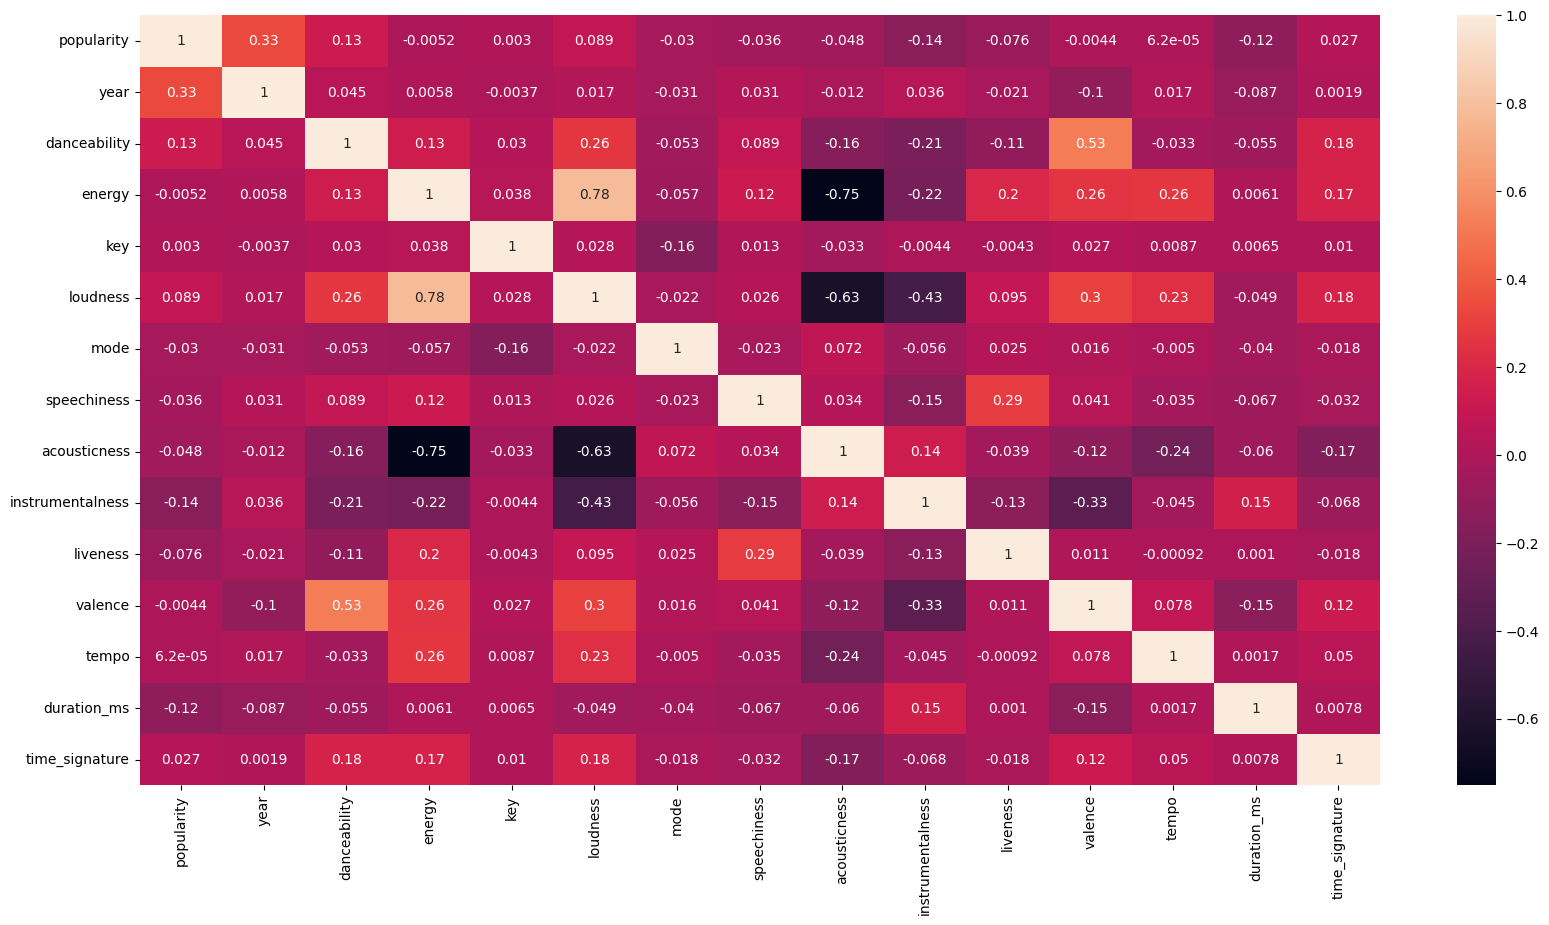

In [28]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(spotify_data.corr(),annot = True)
plt.show()

### 2. Data Preprocessing and Feature Engineering

In [29]:
# We will get rid of the unnecessary columns from the dataset such as track name and track id
spotify_data.drop(['track_name', 'track_id'], axis = 1, inplace = True)

In [30]:
# We have seen that the tempo needs to be transformed as there are lot of values which are 0 hence transforming them to mean value.
def fix_tempo():
    spotify_data.loc[spotify_data['tempo'] == 0 , 'tempo'] = spotify_data.loc[spotify_data['tempo'] > 0 , 'tempo'].mean()

In [31]:
fix_tempo()
spotify_data['tempo'].value_counts()

121.535175    769
119.999000    357
120.002000    346
120.006000    342
128.001000    334
             ... 
173.253000      1
219.933000      1
172.614000      1
66.492000       1
161.509000      1
Name: tempo, Length: 132579, dtype: int64

In [32]:
# We also observed that the duration is in milliseconds and hence converting it into minutes
spotify_data['duration_min'] = round(spotify_data['duration_ms']/60000, 2)
spotify_data['duration_min'].describe()

count    1.001373e+06
mean     4.100293e+00
std      2.322314e+00
min      9.000000e-02
25%      3.030000e+00
50%      3.740000e+00
75%      4.690000e+00
max      1.000100e+02
Name: duration_min, dtype: float64

In [33]:
spotify_data.drop('duration_ms', axis= 1, inplace= True)

In [34]:
spotify_data.head()

,artist_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_min
0,Jason Mraz,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,3,4.00
1,Jason Mraz,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,3.61
2,Joshua Hyslop,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,4,2.65
3,Boyce Avenue,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,4,5.07
4,Andrew Belle,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,4,4.07


In [36]:
spotify_data.drop('artist_name', axis=1, inplace = True)

In [38]:
spotify_data.drop('genre', axis=1, inplace = True)

In [39]:
spotify_data.head()

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_min
0,68,2012,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,3,4.00
1,50,2012,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,3.61
2,57,2012,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,4,2.65
3,58,2012,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,4,5.07
4,54,2012,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,4,4.07


In [40]:
def convert_popularity(popularity_val):
    return int(popularity_val >= 50)

In [41]:
spotify_data['popularity'] = spotify_data['popularity'].apply(convert_popularity)

<Axes: >

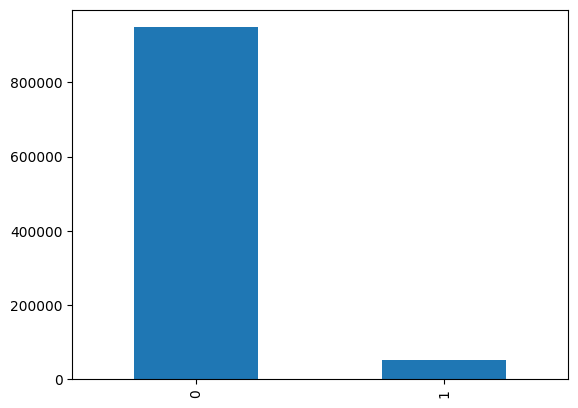

In [43]:
spotify_data['popularity'].value_counts().plot(kind='bar')

### Note: We have imbalanced data as there are very less songs with popularity score more than the threshold we decided based on the third quartile of data

In [29]:
# We are going to encode the year in the dataframe
# le = LabelEncoder()

# spotify_data.year = le.fit_transform(spotify_data.year)

with open('year_encoder_le.pkl', 'rb') as file:
        yr_encoder = pkl.load(file)
with open('catcols_encoder_ohe.pkl', 'rb') as file:
        ohe_encoder = pkl.load(file)
with open('feature_scaler.pkl', 'rb') as file:
        feature_scaler = pkl.load(file)

In [30]:
numeric_cols = [ 'danceability', 'energy', 
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_min']
categorical_cols = ['year','time_signature', 'key']

In [31]:
spotify_data.head()

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_min
0,1,2012,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,3,4.00
1,1,2012,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,3.61
2,1,2012,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,4,2.65
3,1,2012,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,4,5.07
4,1,2012,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,4,4.07


In [32]:
spotify_data['year'] = yr_encoder.transform(spotify_data['year'])
encoded_new_data_df = pd.DataFrame(ohe_encoder.transform(spotify_data[categorical_cols]).toarray(), index=spotify_data.index)
encoded_new_data_df.columns = ohe_encoder.get_feature_names_out()
final_df = pd.concat([spotify_data, encoded_new_data_df], axis=1)
final_df.drop(categorical_cols, axis=1, inplace=True)

In [33]:
final_df.columns

Index(['popularity', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_min', 'year_0', 'year_1', 'year_2',
       'year_3', 'year_4', 'year_5', 'year_6', 'year_7', 'year_8', 'year_9',
       'year_10', 'year_11', 'year_12', 'year_13', 'year_14', 'year_15',
       'year_16', 'year_17', 'year_18', 'year_19', 'year_20', 'year_21',
       'year_22', 'year_23', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5', 'key_0',
       'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8',
       'key_9', 'key_10', 'key_11'],
      dtype='object')

In [48]:
X = final_df.drop('popularity', axis=1).copy()
y = final_df['popularity'].copy()

In [49]:
X.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_min', 'year_0', 'year_1', 'year_2', 'year_3', 'year_4',
       'year_5', 'year_6', 'year_7', 'year_8', 'year_9', 'year_10', 'year_11',
       'year_12', 'year_13', 'year_14', 'year_15', 'year_16', 'year_17',
       'year_18', 'year_19', 'year_20', 'year_21', 'year_22', 'year_23',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')

In [50]:
def get_vif(X_df):
    vif = pd.DataFrame()
    vif['Features'] = X_df.columns
    vif = vif.set_index('Features')
    vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending= False)
    print(vif)


numeric_cols = [   'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence',  'duration_min']
categorical_cols = ['year','time_signature', 'key']

get_vif(X[numeric_cols])

                   VIF
Features              
duration_min      2.92
valence           2.71
mode              2.41
liveness          2.26
acousticness      1.72
speechiness       1.66
instrumentalness  1.54


### Note: <p>We got rid of the multicollinear features step wise with vif score above 5 which can be seen from above list</p>

In [51]:
# We will drop the multicollinear features from our final dataset
X.drop(['danceability', 'energy', 'loudness', 'tempo'], axis=1, inplace= True)

In [52]:
X.columns

Index(['mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'duration_min', 'year_0', 'year_1', 'year_2', 'year_3',
       'year_4', 'year_5', 'year_6', 'year_7', 'year_8', 'year_9', 'year_10',
       'year_11', 'year_12', 'year_13', 'year_14', 'year_15', 'year_16',
       'year_17', 'year_18', 'year_19', 'year_20', 'year_21', 'year_22',
       'year_23', 'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')

In [53]:
sum(y) / len(y)

0.04569033010164137

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify= y)

In [62]:
X_train.columns

Index(['mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'duration_min', 'year_0', 'year_1', 'year_2', 'year_3',
       'year_4', 'year_5', 'year_6', 'year_7', 'year_8', 'year_9', 'year_10',
       'year_11', 'year_12', 'year_13', 'year_14', 'year_15', 'year_16',
       'year_17', 'year_18', 'year_19', 'year_20', 'year_21', 'year_22',
       'year_23', 'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')

In [63]:
sum(y_test) / len(y_test)

0.045690290705444635

In [64]:
# We will perform scaling to fit the value between min and max, however the fit should not be done on test dataset and only transform must be done.
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
output = open('feature_scaler.pkl', 'wb')
pkl.dump(scaler, output)
output.close()

In [66]:
X_train.head()

,mode,speechiness,acousticness,instrumentalness,liveness,valence,duration_min,year_0,year_1,year_2,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
1158856,-1.318426,0.607237,-0.904513,-0.077449,-0.403211,-1.355748,-0.770093,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1412869,0.758480,-0.251077,-0.901897,-0.691071,-0.618004,0.202893,-0.099535,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
622397,0.758480,-0.299111,-0.886996,-0.691071,0.327683,-0.940756,-0.277273,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894797,-1.318426,1.056080,-0.260504,-0.691071,0.049247,1.365169,-0.479249,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
846287,-1.318426,-0.166820,0.843646,-0.691071,0.556398,0.512089,-0.313629,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Now that we have our data ready we need to do resampling as we have minority class at low ratio compared to majority class and therefore, we will perform smotetomek for resampling.

In [80]:
adsyn = ADASYN(random_state=42)
#Takes around 11 minutes to oversample the data for minority class
#Before smotetomek
print('Before performing the oversampling technique: ', Counter(y_train))
X_train_ad, y_train_ad = adsyn.fit_resample(X_train, y_train)

#After Smotetomek
print('After performing the oversampling technique: ', Counter(y_train_ad))

Before performing the oversampling technique:  Counter({0: 885419, 1: 42392})
After performing the oversampling technique:  Counter({0: 885419, 1: 884560})


In [84]:
print(Counter(y_train))
print(Counter(y_train_ad))

Counter({0: 885419, 1: 42392})
Counter({0: 885419, 1: 884560})


## Model Creation using various methods
#### 1. Logistic regression

In [91]:
parameters = {
    'max_iter' : [20,50,100]
}
best_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, verbose= 1, scoring= 'f1', cv = 3, n_jobs=-1)
best_lr.fit(X_train_ad, y_train_ad)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [20, 50, 100]}, scoring='f1', verbose=1)

In [92]:
best_lr.best_estimator_,best_lr.best_params_,best_lr.best_score_

(LogisticRegression(max_iter=20), {'max_iter': 20}, 0.7065801521237827)

In [95]:
best_lr_final = LogisticRegression(max_iter=20)
best_lr_final.fit(X_train_ad, y_train_ad)
y_pred_lr = best_lr_final.predict(X_test)

In [154]:
with open('best_logistic_regression', 'wb') as files:
    pkl.dump(best_lr_final, files)

In [96]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83    221355
           1       0.11      0.71      0.18     10598

    accuracy                           0.71    231953
   macro avg       0.54      0.71      0.50    231953
weighted avg       0.94      0.71      0.80    231953



In [97]:
round(roc_auc_score(y_test, y_pred_lr),4)

0.7095

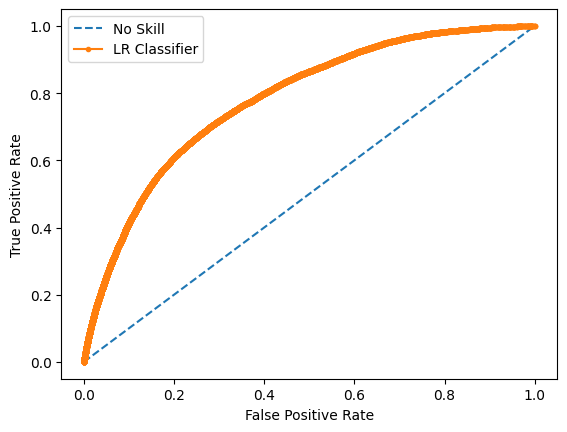

In [98]:
lr_probs = best_lr_final.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LR Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [167]:
p = precision_score(y_test, y_pred_lr)
r = recall_score(y_test, y_pred_lr)
f = fbeta_score(y_test, y_pred_lr, beta=2.0)
print('Result: precision=%.3f, recall=%.3f, fscore=%.3f' % (p, r, f))

Result: precision=0.105, recall=0.707, fscore=0.330


#### 2. AdaBoost Classifier

In [99]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced'), n_estimators=200, algorithm="SAMME.R", learning_rate=1)

In [100]:
ada_clf.fit(X_train_ad, y_train_ad)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   learning_rate=1, n_estimators=200)

In [101]:
ada_predict = ada_clf.predict(X_test)

In [102]:
print(classification_report(y_test,ada_predict))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    221355
           1       0.12      0.67      0.20     10598

    accuracy                           0.75    231953
   macro avg       0.55      0.71      0.52    231953
weighted avg       0.94      0.75      0.82    231953



In [103]:
output = open('ada_boost_best.pkl', 'wb')
pkl.dump(ada_clf, output)
output.close()

In [113]:
opt = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    {
        'n_estimators' : [100,150,200],
        'learning_rate' : [0.05,0.5,1],
    },
    cv=3,
    scoring='f1',
    n_jobs=-1
)

In [114]:
opt.fit(X_train_ad, y_train_ad)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.5, 1],
                         'n_estimators': [100, 150, 200]},
             scoring='f1')

In [115]:
opt.best_estimator_,opt.best_params_,opt.best_score_

(AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=42),
 {'learning_rate': 1, 'n_estimators': 200},
 0.7854653020107518)

In [116]:
y_pred_ad = opt.predict(X_test)

In [153]:
with open('best_adaboost_classifier.pkl', 'wb') as files:
    pkl.dump(opt, files)

In [117]:
print(classification_report(y_test,y_pred_ad))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85    221355
           1       0.12      0.67      0.20     10598

    accuracy                           0.75    231953
   macro avg       0.55      0.71      0.52    231953
weighted avg       0.94      0.75      0.82    231953



In [118]:
round(roc_auc_score(y_test, y_pred_ad),4)

0.7121

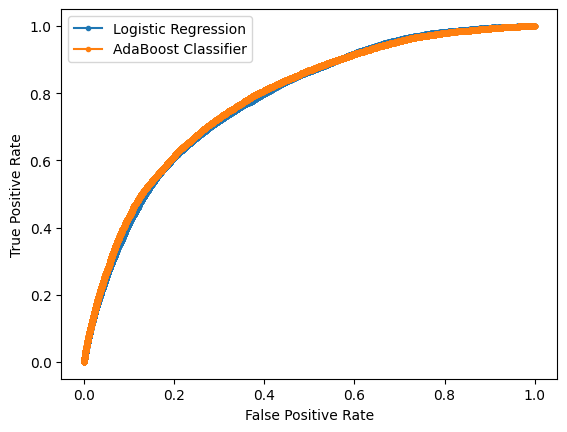

In [122]:
ad_probs = opt.predict_proba(X_test)
ad_probs = ad_probs[:, 1]
ad_auc = roc_auc_score(y_test, ad_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_ad, tpr_ad, _ = roc_curve(y_test, ad_probs)
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
plt.plot(fpr_ad, tpr_ad, marker='.', label='AdaBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [168]:
p = precision_score(y_test, y_pred_ad)
r = recall_score(y_test, y_pred_ad)
f = fbeta_score(y_test, y_pred_ad, beta=2.0)
print('Result: precision=%.3f, recall=%.3f, fscore=%.3f' % (p, r, f))

Result: precision=0.115, recall=0.671, fscore=0.342


#### 3. Random Forest Classifier

In [127]:
parameters = {
    'max_depth' : [10,20,50],
    'min_samples_leaf' : [2,5,10], 
    'n_estimators' : [60,100,150]
}
best_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100,
                                               class_weight='balanced', min_samples_leaf =5), param_grid = parameters, verbose= 1, scoring= 'f1', cv = 3, n_jobs=-1)
best_rf.fit(X_train_ad, y_train_ad)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_leaf=5),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [60, 100, 150]},
             scoring='f1', verbose=1)

In [128]:
best_rf.best_estimator_,best_rf.best_params_,best_rf.best_score_

(RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=2, n_estimators=60),
 {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 60},
 0.7750516743774406)

In [129]:
best_rf_final = RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=2, n_estimators=60)
best_rf_final.fit(X_train_ad, y_train_ad)
y_pred_rf = best_rf_final.predict(X_test)

In [148]:
with open('best_random_forest.pkl', 'wb') as files:
    pkl.dump(best_rf_final, files)

In [130]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    221355
           1       0.10      0.74      0.17     10598

    accuracy                           0.68    231953
   macro avg       0.54      0.71      0.49    231953
weighted avg       0.94      0.68      0.77    231953



In [131]:
round(roc_auc_score(y_test, y_pred_rf),4)

0.7072

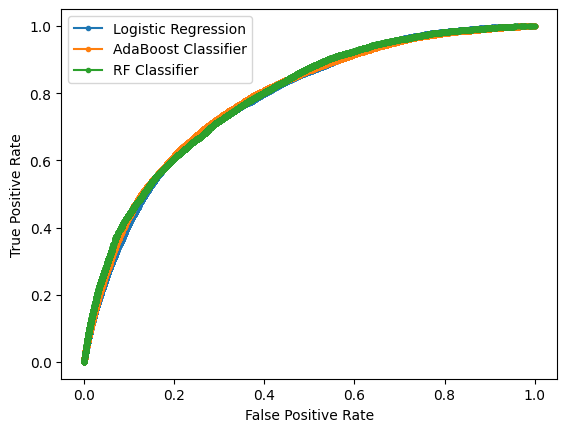

In [133]:
rf_probs = best_rf_final.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_ad, tpr_ad, _ = roc_curve(y_test, ad_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
plt.plot(fpr_ad, tpr_ad, marker='.', label='AdaBoost Classifier')
plt.plot(fpr_rf, tpr_rf, marker='.', label='RF Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [169]:
p = precision_score(y_test, y_pred_rf)
r = recall_score(y_test, y_pred_rf)
f = fbeta_score(y_test, y_pred_rf, beta=2.0)
print('Result: precision=%.3f, recall=%.3f, fscore=%.3f' % (p, r, f))

Result: precision=0.098, recall=0.739, fscore=0.321


#### 4. Catboost Classifier

In [137]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
CBC = CatBoostClassifier(class_weights=class_weights)
parameters = {'depth'         : [5,10,15],
              'learning_rate' : [0.05,0.1,0.5],
              'iterations'    : [50,100,120]
              }
best_cbc = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1)
best_cbc.fit(X_train_ad, y_train_ad)

0:	learn: 0.6255920	total: 291ms	remaining: 14.3s
1:	learn: 0.5612429	total: 445ms	remaining: 10.7s
2:	learn: 0.5079024	total: 603ms	remaining: 9.44s
3:	learn: 0.4633710	total: 768ms	remaining: 8.83s
4:	learn: 0.4223802	total: 927ms	remaining: 8.34s
5:	learn: 0.3876194	total: 1.07s	remaining: 7.88s
6:	learn: 0.3572322	total: 1.26s	remaining: 7.73s
7:	learn: 0.3328810	total: 1.39s	remaining: 7.32s
8:	learn: 0.3098854	total: 1.54s	remaining: 7.04s
9:	learn: 0.2911361	total: 1.69s	remaining: 6.78s
10:	learn: 0.2752276	total: 1.86s	remaining: 6.58s
11:	learn: 0.2597750	total: 2.04s	remaining: 6.46s
12:	learn: 0.2480553	total: 2.22s	remaining: 6.32s
13:	learn: 0.2361678	total: 2.39s	remaining: 6.15s
14:	learn: 0.2263501	total: 2.55s	remaining: 5.96s
15:	learn: 0.2177717	total: 2.72s	remaining: 5.77s
16:	learn: 0.2112115	total: 2.88s	remaining: 5.6s
17:	learn: 0.2045866	total: 3.03s	remaining: 5.39s
18:	learn: 0.1988526	total: 3.2s	remaining: 5.22s
19:	learn: 0.1943330	total: 3.35s	remaining

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020BBDD9A650>,
             n_jobs=-1,
             param_grid={'depth': [5, 10, 15], 'iterations': [50, 100, 120],
                         'learning_rate': [0.05, 0.1, 0.5]})

In [138]:
print(best_cbc.best_estimator_)
print(best_cbc.best_score_)
print(best_cbc.best_params_)

0.5378611836637609
{'depth': 5, 'iterations': 50, 'learning_rate': 0.05}


In [139]:
best_cb = CatBoostClassifier(depth=5, iterations=50, learning_rate=0.5, random_state=42)
best_cb.fit(X_train_ad, y_train_ad)
y_pred_cb = best_cb.predict(X_test)

0:	learn: 0.5986951	total: 144ms	remaining: 7.08s
1:	learn: 0.5669768	total: 280ms	remaining: 6.71s
2:	learn: 0.5471699	total: 429ms	remaining: 6.72s
3:	learn: 0.5315626	total: 558ms	remaining: 6.41s
4:	learn: 0.5163274	total: 689ms	remaining: 6.2s
5:	learn: 0.4991408	total: 817ms	remaining: 5.99s
6:	learn: 0.4908108	total: 949ms	remaining: 5.83s
7:	learn: 0.4844948	total: 1.07s	remaining: 5.63s
8:	learn: 0.4782014	total: 1.21s	remaining: 5.49s
9:	learn: 0.4733502	total: 1.34s	remaining: 5.35s
10:	learn: 0.4675081	total: 1.46s	remaining: 5.19s
11:	learn: 0.4625513	total: 1.59s	remaining: 5.04s
12:	learn: 0.4585883	total: 1.73s	remaining: 4.92s
13:	learn: 0.4541484	total: 1.86s	remaining: 4.79s
14:	learn: 0.4513530	total: 1.99s	remaining: 4.65s
15:	learn: 0.4481324	total: 2.13s	remaining: 4.52s
16:	learn: 0.4424755	total: 2.26s	remaining: 4.39s
17:	learn: 0.4393396	total: 2.4s	remaining: 4.26s
18:	learn: 0.4373042	total: 2.53s	remaining: 4.12s
19:	learn: 0.4348113	total: 2.66s	remaining

In [140]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88    221355
           1       0.12      0.61      0.21     10598

    accuracy                           0.78    231953
   macro avg       0.55      0.70      0.54    231953
weighted avg       0.94      0.78      0.85    231953



In [141]:
round(roc_auc_score(y_test, y_pred_cb),4)

0.7032

In [142]:
cb_probs = best_cb.predict_proba(X_test)
cb_probs = cb_probs[:, 1]
rf_auc = roc_auc_score(y_test, cb_probs)
rf_auc

0.7893709056926226

In [143]:
print(confusion_matrix(y_test, y_pred_cb))

[[175571  45784]
 [  4098   6500]]


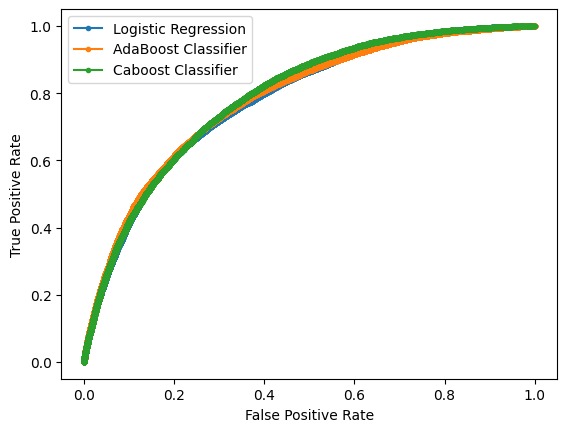

In [144]:
cb_probs = best_cb.predict_proba(X_test)
cb_probs = cb_probs[:, 1]
cb_auc = roc_auc_score(y_test, cb_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_ad, tpr_ad, _ = roc_curve(y_test, ad_probs)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
plt.plot(fpr_ad, tpr_ad, marker='.', label='AdaBoost Classifier')
plt.plot(fpr_cb, tpr_cb, marker='.', label='Caboost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [149]:
# Saving the model so as to not lose any progress
with open('best_catboost_classifier_pkl', 'wb') as files:
    pkl.dump(best_cb, files)

In [150]:
with open('best_catboost_classifier_pkl', 'rb') as cb_file:
    cb_saved = pkl.load(cb_file)

In [151]:
type(cb_saved)

catboost.core.CatBoostClassifier

In [170]:
p = precision_score(y_test, y_pred_cb)
r = recall_score(y_test, y_pred_cb)
f = fbeta_score(y_test, y_pred_cb, beta=2.0)
print('Result: precision=%.3f, recall=%.3f, fscore=%.3f' % (p, r, f))

Result: precision=0.124, recall=0.613, fscore=0.343


#### 5. XGBClassifier

In [155]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=-1, cv=3)
xgb1.fit(X_train_ad,y_train_ad)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
           

In [156]:
xgb1.best_params_, xgb1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8489665833582226)

In [ ]:
param_test_2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test_2, scoring='roc_auc',n_jobs=-1, cv=5)
xgb2.fit(X_train_ad,y_train_ad)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=9,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'max_depth': [11, 12, 13]},
             scoring='roc_auc')

In [ ]:
xgb2.best_params_, xgb2.best_score_

({'max_depth': 13}, 0.9913610873981653)

In [158]:
best_xgb = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=5, seed=27)
best_xgb.fit(X_train_ad, y_train_ad)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [159]:
y_pred_xgb = best_xgb.predict(X_test)

In [160]:
print(confusion_matrix(y_test, y_pred_xgb))

[[126006  95349]
 [  1563   9035]]


In [161]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72    221355
           1       0.09      0.85      0.16     10598

    accuracy                           0.58    231953
   macro avg       0.54      0.71      0.44    231953
weighted avg       0.95      0.58      0.70    231953



In [163]:
xgb_probs = best_xgb.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_auc

0.7938383863417626

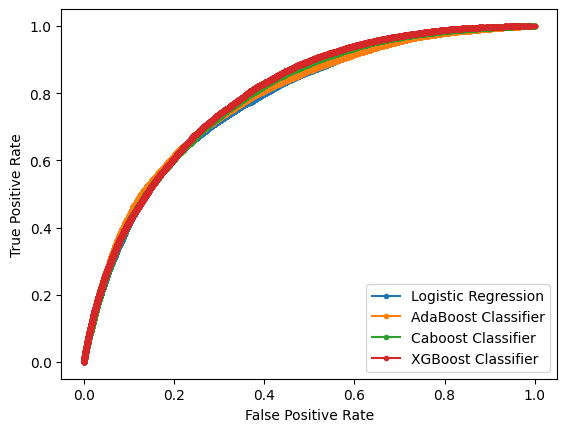

In [162]:
xgb_probs = best_xgb.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
fpr_xg, tpr_xg, _ = roc_curve(y_test, xgb_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_ad, tpr_ad, _ = roc_curve(y_test, ad_probs)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)
plt.plot(fpr_lr, tpr_lr, marker='.', label='Logistic Regression')
plt.plot(fpr_ad, tpr_ad, marker='.', label='AdaBoost Classifier')
plt.plot(fpr_cb, tpr_cb, marker='.', label='Caboost Classifier')
plt.plot(fpr_xg, tpr_xg, marker='.', label='XGBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [164]:
# Saving the model so as to not lose any progress
with open('best_xgboost_pkl', 'wb') as files:
    pkl.dump(best_xgb, files)

In [171]:
p = precision_score(y_test, y_pred_xgb)
r = recall_score(y_test, y_pred_xgb)
f = fbeta_score(y_test, y_pred_xgb, beta=2.0)
print('Result: precision=%.3f, recall=%.3f, fscore=%.3f' % (p, r, f))

Result: precision=0.087, recall=0.853, fscore=0.308


#### Conclusions:
1. Performed resampling using ADASYN as the other methods didn't show significantly high results and it was faster to compute.
2. Out of 5 different classifiers, CatBoost outperformed all of them with higher F1 score.
3. Hyperparameter tuning using gridsearch cv helped in figuring out the best parameters needed for classifying. 
4. Boosting methods can be helpful to handle in case of imbalanced class problems as it gives an edge of penalizing the model for every misclassification for minority class.
5. Recall is an appropriate metric other than F1 score as we could afford an unpopular song getting predicted as popular but a hit shouldn't be classified as unpopular.
6. This is helpful in cases where the music industry members want to verify how the track will perform.

#### Future Scope:
<p>We can get the lyrics and use techniques of NLP to further enhance the model. It is observed that the songs with an explicit content tend to have high popularity and this would be a good approach to further classify our songs.</p>